Davies-Bouldin Index: 0.8935003798461565


C:\Users\vijay\AppData\Local\Temp/ipykernel_7684/3481812880.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  customer_data.fillna(customer_data.mean(), inplace=True)  # Fill NaN values with column mean
C:\Users\vijay\AppData\Local\Temp/ipykernel_7684/3481812880.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  customer_data.fillna(customer_data.mean(), inplace=True)  # Fill any remaining NaNs with column mean


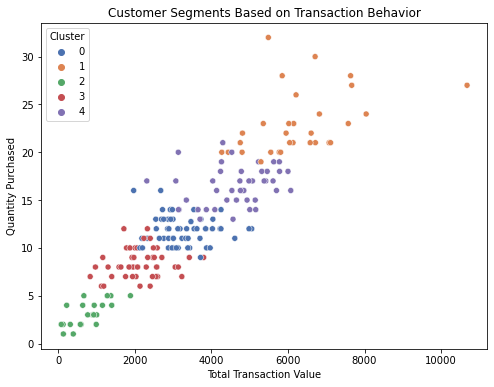

Silhouette Score: 0.35627642853533886


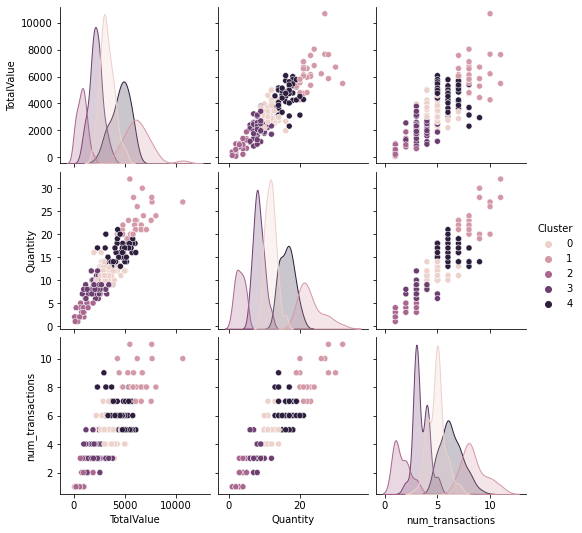

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Transactions dataset
transactions_file = "C:\\Users\\vijay\\Videos\\data science\\project\\Transactions.csv"
data3 = pd.read_csv(transactions_file)

# Load the Customers dataset
customers_file = "C:\\Users\\vijay\\Videos\\data science\\project\\Customers.csv"
data1 = pd.read_csv(customers_file)

# Calculate the number of transactions per customer (assuming each row is a transaction)
data3['num_transactions'] = data3.groupby('CustomerID')['CustomerID'].transform('count')

# Aggregate transaction data
transaction_summary = data3.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'num_transactions': 'first',  # We already calculated the number of transactions, so take the first occurrence
}).reset_index()

# Merge with customer data
customer_data = data1[['CustomerID', 'Region']]  # Assuming 'Region' is the column you want to keep
customer_data = customer_data.merge(transaction_summary, on='CustomerID', how='left')

# Handle missing values (NaN)
customer_data.fillna(customer_data.mean(), inplace=True)  # Fill NaN values with column mean

# Handle infinite values by replacing them with a large number or removing rows
customer_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
customer_data.fillna(customer_data.mean(), inplace=True)  # Fill any remaining NaNs with column mean

# Feature engineering (scaling numerical data)
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['TotalValue', 'Quantity', 'num_transactions']])

# Perform KMeans clustering (let's assume 5 clusters for this example)
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Evaluate the clustering with DB Index
db_index = davies_bouldin_score(customer_data_scaled, customer_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualizing clusters in 2D space (TotalValue vs Quantity)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TotalValue', y='Quantity', hue='Cluster', data=customer_data, palette='deep')
plt.title("Customer Segments Based on Transaction Behavior")
plt.xlabel("Total Transaction Value")
plt.ylabel("Quantity Purchased")
plt.show()

# Calculate silhouette score
silhouette_avg = silhouette_score(customer_data_scaled, customer_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

# Pairplot to visualize all relationships between features and clusters
sns.pairplot(customer_data, hue='Cluster', vars=['TotalValue', 'Quantity', 'num_transactions'])
plt.show()

# Save the clustering result
customer_data[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation_Result.csv', index=False)

# Save clustering report as text
report = f"""
Customer Segmentation Report:
- Number of Clusters: 5
- Davies-Bouldin Index: {db_index}
- Silhouette Score: {silhouette_avg}

Clusters were formed based on transaction behavior: total value spent, quantity purchased, and number of transactions.
"""
with open("Customer_Segmentation_Report.txt", "w") as file:
    file.write(report)

    